In [1]:
from datasets import load_dataset, concatenate_datasets

In [17]:
import numpy as np

def get_stats(data):
    words_num = data.map(lambda x: {"text_words_num": len(x["text"].split()), "summary_words_num": len(x["summary"].split())})
    avg_words_num_text = np.mean(words_num["text_words_num"])
    avg_words_num_summary = np.mean(words_num["summary_words_num"])

    return avg_words_num_text, avg_words_num_summary

In [18]:
data1 = load_dataset("reciTAL/mlsum", 'ru')

full_data1 = concatenate_datasets([
    data1["train"],
    data1["validation"],
    data1["test"]
])
full_data1 = full_data1.remove_columns(['topic', 'url', 'title', 'date'])
print(len(full_data1))

get_stats(full_data1)

27063


(790.2411040904556, 12.775006466393231)

In [19]:
data2 = load_dataset("IlyaGusev/gazeta")

full_data2 = concatenate_datasets([
    data2["train"],
    data2["validation"],
    data2["test"]
])
full_data2 = full_data2.remove_columns(['title', 'date', 'url'])
print(len(full_data2))

get_stats(full_data2)

74126


(628.2115721878963, 42.660550953781396)

In [20]:
data3 = load_dataset("csebuetnlp/xlsum", "russian")

full_data3 = concatenate_datasets([
    data3["train"],
    data3["test"],
    data3["validation"]
])
full_data3 = full_data3.remove_columns(['id', 'url', 'title'])
print(len(full_data3))

get_stats(full_data3)

77803


(547.6641132090023, 25.173039600015425)

In [21]:
data4 = load_dataset("GEM/wiki_lingua", "ru")

full_data4 = concatenate_datasets([
    data4["train"],
    data4["validation"],
    data4["test"]
])
full_data4 = full_data4.remove_columns(['gem_id', 'gem_parent_id', 'source_language', 'target_language', 'references'])
full_data4 = full_data4.rename_columns({"source": "text", "target": "summary"})
print(len(full_data4))

get_stats(full_data4)

50259


(321.91860164348674, 27.94172188065819)

In [ ]:
combined_data = concatenate_datasets([full_data1, full_data2, full_data3, full_data4])
combined_data.save_to_disk("../data/combined_data")

Saving the dataset (0/4 shards):   0%|          | 0/229251 [00:00<?, ? examples/s]

In [17]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRED-T5-large")

MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 300
TASK_PROMPT = "<LM> Сократи текст: "

def is_short_enough(example):
    text_tokens = tokenizer(
        TASK_PROMPT + example["text"],
        truncation=False,
    )["input_ids"]

    summary_tokens = tokenizer(
        example["summary"],
        truncation=False,
    )["input_ids"]

    return len(text_tokens) < MAX_INPUT_LENGTH and len(summary_tokens) < MAX_TARGET_LENGTH

def count_truncations(example):
    input_tokens = tokenizer(TASK_PROMPT + example["text"])["input_ids"]
    target_tokens = tokenizer(example["summary"])["input_ids"]
    return {
        "input_truncated": len(input_tokens) > MAX_INPUT_LENGTH,
        "target_truncated": len(target_tokens) > MAX_TARGET_LENGTH
    }

# input_trunc_count = sum(truncation_stats["input_truncated"])
# target_trunc_count = sum(truncation_stats["target_truncated"])

# TEST

In [2]:
from datasets import load_dataset

raw = load_dataset("RussianNLP/Mixed-Summarization-Dataset")
raw = raw['test']

In [24]:
import pandas as pd

test = pd.read_csv("../data/test_hand_instruct.csv", sep="|")

In [35]:
test["source_words"] = test["text"].apply(lambda x: len([token for token in word_tokenize(x, language='russian') if token.isalpha()]))
test["target_words"] = test["summary"].apply(lambda x: len([token for token in word_tokenize(x, language='russian') if token.isalpha()]))

<Axes: >

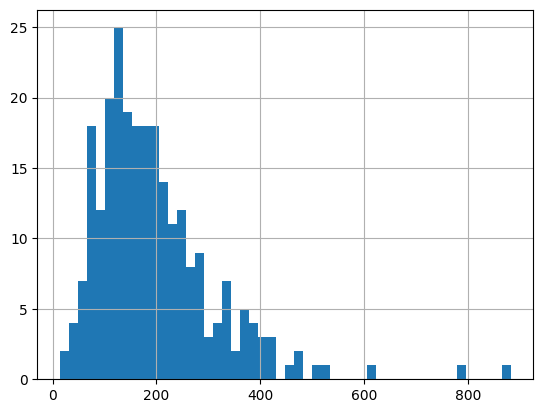

In [39]:
test[test["source_words"]<1000]["source_words"].hist(bins=50)

<Axes: >

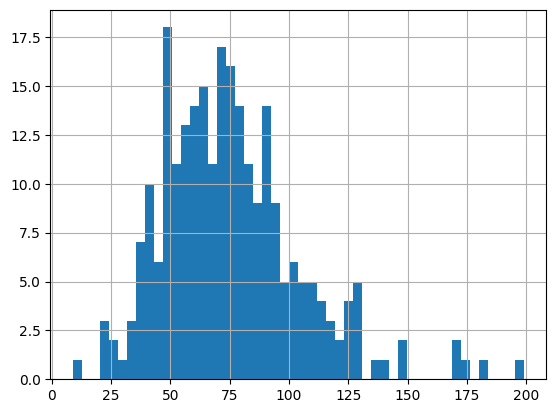

In [40]:
test[test["target_words"]<200]["target_words"].hist(bins=50)

In [6]:
from datasets import Dataset

filtered_test = Dataset.from_pandas(test).filter(is_short_enough)

def remove_instruction(example):
    text = example['text']
    return {'text': text.split('\n', 1)[-1].strip()[1:-1]}
filtered_test = filtered_test.map(remove_instruction)

Filter:   0%|          | 0/258 [00:00<?, ? examples/s]

Map:   0%|          | 0/247 [00:00<?, ? examples/s]

In [ ]:
filtered_test.save_to_disk('../data/filtered_test')

Saving the dataset (0/1 shards):   0%|          | 0/247 [00:00<?, ? examples/s]

# TRAIN

In [ ]:
from datasets import load_from_disk

train = load_from_disk('../data/combined_data')
train_filtered = train.filter(is_short_enough, num_proc=16)

In [18]:
from nltk.tokenize import word_tokenize

def count(example):
    input_tokens = tokenizer(TASK_PROMPT + example["text"])["input_ids"]
    target_tokens = tokenizer(example["summary"])["input_ids"]
    source_words = len([token for token in word_tokenize(example['text'], language='russian') if token.isalpha()])
    target_words = len([token for token in word_tokenize(example['summary'], language='russian') if token.isalpha()])
    return {
        "input_tokens": len(input_tokens),
        "target_tokens": len(target_tokens),
        "source_words": source_words,
        "target_words": target_words,
    }
# data_stats = train_filtered.map(count, num_proc=16)

In [ ]:
# import evaluate
# bertscore = evaluate.load("bertscore")

# def compute_bertscore_batch(batch):
#     results = bertscore.compute(predictions=batch["summary"],
#                                 references=batch["text"],
#                                 lang="ru", device="cuda:0", batch_size=126)
#     return {"bertscore_f1": results["f1"], "bertscore_precision": results["precision"], "bertscore_recall": results["recall"]}
# scored_dataset = train_filtered.map(compute_bertscore_batch, batched=True, batch_size=256)

In [ ]:
# import pandas as pd

# df1 = pd.read_csv("../data/bertscore40000.csv")
# df2 = pd.read_csv("../data/bertscore80000.csv")
# df3 = pd.read_csv("../data/bertscore120000.csv")
# df4 = pd.read_csv("../data/bertscore173138.csv")

# df_ = pd.concat([df1, df2, df3, df4], ignore_index=True)
# df_.drop(columns=["Unnamed: 0", 'text', 'summary'], inplace=True)

# df = pd.concat([pd.DataFrame(data_stats), df_], axis=1)
# df.to_csv("../data/data_stats.csv")

In [29]:
import pandas as pd

df = pd.read_csv("../data/data_stats.csv")

In [30]:
# df_ = pd.concat([df1, df2, df3, df4], ignore_index=True)
# for i in range(len(df)):
#     assert df.iloc[i]['summary'] == df_.iloc[i]['summary'], f"{i}"
df.shape

(173138, 10)

In [35]:
dupes = df[df.duplicated('text', keep=False)].sort_values('text')
# SEARCH FOR DUPLICATES
for text, group in dupes.groupby('text'):
    print(f"\n--- TEXT ---\n{text[:300]}")
    print("--- SUMMARIES ---")
    for _, row in group.iterrows():
        print(f"- {row['bertscore_f1']:.4f} {row['summary']}")


In [32]:
df = (
    df.assign(summary_length=lambda d: d['target_words'])
      .sort_values(by=['text', 'summary_length'], ascending=[True, False])
      .drop_duplicates(subset='text', keep='first')
      .drop(columns=['summary_length'])
)

In [33]:
df = (
    df.assign(text_length=lambda d: d['source_words'])
      .sort_values(by=['summary', 'text_length'], ascending=[True, False])
      .drop_duplicates(subset='summary', keep='first')
      .drop(columns=['text_length'])
)

In [34]:
df.sort_index(inplace=True)

In [36]:
from datasets import Dataset
from langdetect import detect

dataset = Dataset.from_pandas(df)
dataset = dataset.map(lambda x: {"lang": detect(x["text"])}, num_proc=20)

Map (num_proc=20):   0%|          | 0/171329 [00:00<?, ? examples/s]

In [37]:
df = dataset.to_pandas()

In [38]:
df = df.reset_index()
df.drop(columns=["__index_level_0__"], inplace=True)

In [39]:
df['compression_ratio_words'] = df['target_words'] / df['source_words']

In [ ]:
# df.to_csv("../data/dedup_data.csv", index=False)

<Axes: >

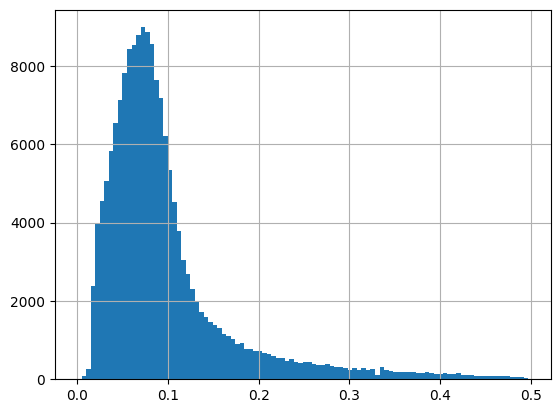

In [54]:
df[df["compression_ratio_words"]<0.5]["compression_ratio_words"].hist(bins=100)

<Axes: >

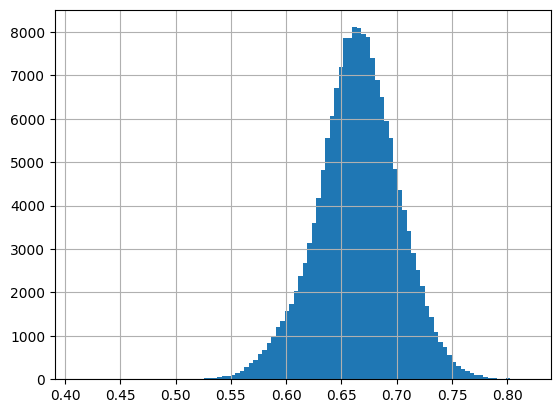

In [46]:
df['bertscore_f1'].hist(bins=100)

<Axes: >

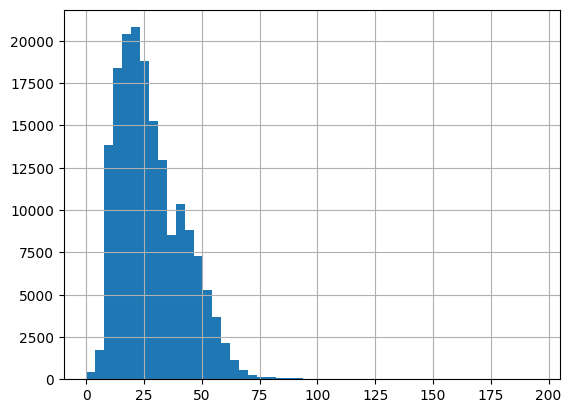

In [47]:
df['target_words'].hist(bins=50)

In [21]:
for i in df[(df["bertscore_f1"] > 0.65) & (df["compression_ratio_words"] > 10) & (df["compression_ratio_words"] < 30) & (df["lang"] == "ru") & (df["target_words"] < 20)].sample(1).iterrows():
    print(i[1]["source_words"], i[1]["text"])
    print(i[1]["target_words"], i[1]["summary"])
    print(i[1]["compression_ratio_words"])

246 На волнах Радио Ватикана прозвучали цитаты из речи Папы. В частности, он назвал насилие над детьми "моральным разрушительным ударом, нанесенным служителями церкви", и заверил, что последуют санкции. По мнению многих, это самое жесткое заявление понтифика на эту тему с момента его восхождения на престол. В марте папа горячо доказывал, что Римская католическая церковь преуспела в борьбе с сексуальными домогательствами священников. "Никто не сделал больше в деле борьбы с сексуальным насилием над детьми. При этом церковь единственная, кто подвергается нападкам", - сказал тогда понтифик. Это была реакция на критику со стороны ООН. В своем докладе Организация Объединенных Наций обвинила Ватикан в систематическом покрывании педофилов ради сохранения репутации церкви. "Быть жестче" В прошлом году по инициативе Папы Римского была создана специальная комиссия для оказания помощи жертвам сексуального насилия. Однако многие католики посчитали этот шаг Франциска недостаточным, сообщает из Рима 

In [81]:
# df1 = df[(df["bertscore_f1"] > 0.65) & (df["compression_ratio_words"] > 10) & (df["compression_ratio_words"] < 30) & (df["target_words"] >= 20) & (df["lang"] == "ru")]
df1 = df[(df["bertscore_f1"] > 0.65) & (df["compression_ratio_words"] > 0.09) & (df["compression_ratio_words"] < 0.6) & (df["target_words"] >= 20) & (df["lang"] == "ru")]
df1.shape

(45695, 13)

<Axes: >

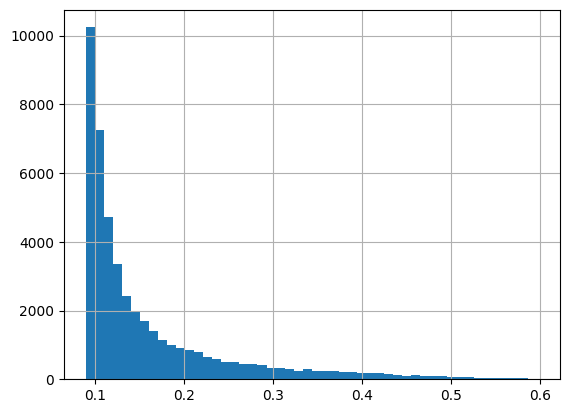

In [111]:
df1['compression_ratio_words'].hist(bins=50)

<Axes: >

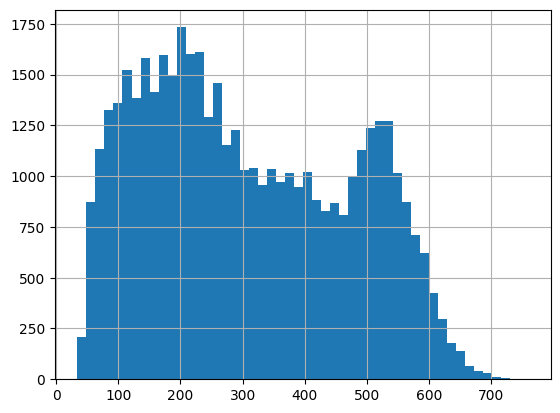

In [84]:
df1['source_words'].hist(bins=50)

<Axes: >

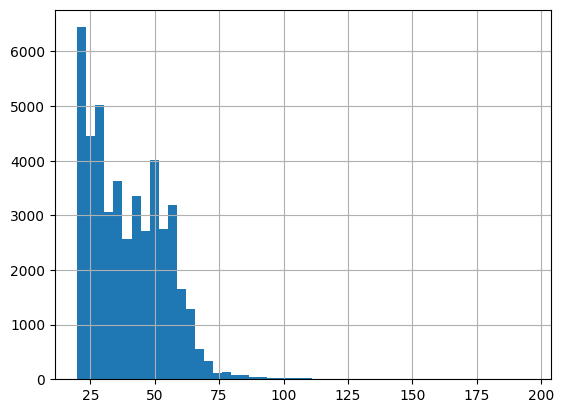

In [82]:
df1['target_words'].hist(bins=50)

<Axes: >

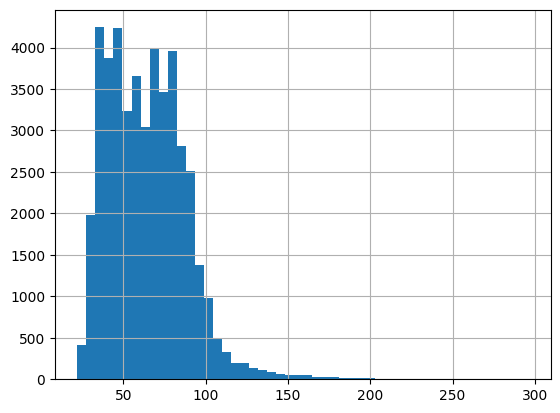

In [72]:
df1['target_tokens'].hist(bins=50)

<Axes: >

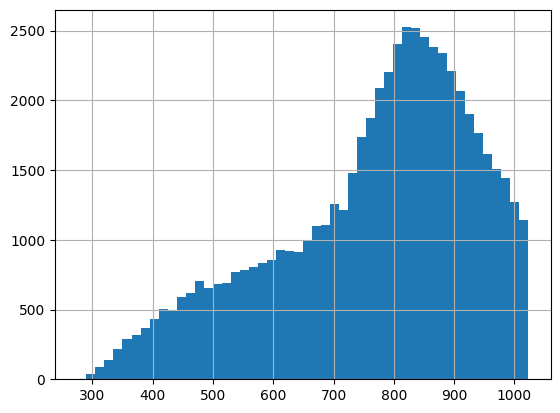

In [25]:
df1['input_tokens'].hist(bins=50)

In [86]:
df1.to_csv("../data/filtered_dedup_data.csv", index=False)

In [87]:
from datasets import Dataset 

Dataset.from_pandas(df1).save_to_disk("../data/filtered_dedup_data")

Saving the dataset (0/1 shards):   0%|          | 0/45695 [00:00<?, ? examples/s]

In [1]:
from datasets import load_from_disk

load_from_disk('../data/filtered_dedup_data')

Dataset({
    features: ['index', 'Unnamed: 0', 'text', 'summary', 'input_tokens', 'target_tokens', 'source_words', 'target_words', 'bertscore_f1', 'bertscore_precision', 'bertscore_recall', 'lang', 'compression_ratio_words', '__index_level_0__'],
    num_rows: 45695
})

# Synthetic Summaries Filtering

In [ ]:
# import pandas as pd
# import json
# with open('gpt/train_data.json', 'r') as fin:
#     articles = [json.loads(s) for s in fin.readlines()]

# df = pd.DataFrame(articles)

# df["input_len"] = df["input_ids"].apply(lambda x: len(x))
# print(df["input_len"].describe())
# df["input_len"].hist(bins=50)

# df['words'] = df['Text'].apply(lambda x: len(x.split()))
# df["input_len"] = df["Text"].apply(lambda x: len(tokenizer(x)["input_ids"]))
# df["input_len"].describe()

In [5]:
from datasets import load_from_disk, concatenate_datasets

nplus1_raw = load_from_disk("../../nplus1_gemini")
fontanka_raw = load_from_disk("../../fontanka_gemini")
synth_raw = concatenate_datasets([nplus1_raw, fontanka_raw])

In [3]:
import re
from nltk.tokenize import sent_tokenize

link_pattern = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)

def remove_link_sentences(text):
    if text is None:
        return text, 0
    sentences = sent_tokenize(text, language='russian')
    clean_sentences = [s for s in sentences if not link_pattern.search(s)]
    changed = int(len(clean_sentences) < len(sentences))
    return ' '.join(clean_sentences), changed

def process_entry(x):
    total_removed = 0
    new_summaries = []
    for i in x["summaries"]:
        new_text, removed = remove_link_sentences(i)
        new_summaries.append(new_text)
        total_removed += removed
    x["summaries"] = new_summaries
    x["removed_count"] = total_removed
    return x


In [ ]:

synth_raw = synth_raw.map(process_entry, num_proc=4)

total_removed = sum(synth_raw["removed_count"])
print(f"Total removed: {total_removed}")


In [4]:
from sentence_transformers import SentenceTransformer, util
import torch

MODEL_NAME = "intfloat/multilingual-e5-large"

def select_best_summary(examples):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SentenceTransformer(MODEL_NAME, device=device)

    source_texts = examples['text']
    candidate_summaries_list = examples['summaries']

    all_texts_to_encode = []
    candidate_indices_in_flat_list_per_example = []
    current_flat_index = 0

    for text, summaries in zip(source_texts, candidate_summaries_list):
        all_texts_to_encode.append("query: " + text)
        current_flat_index += 1

        current_example_candidate_indices = []
        for summary in summaries:
            all_texts_to_encode.append("passage: " + summary.strip())
            current_example_candidate_indices.append(current_flat_index)
            current_flat_index += 1

        candidate_indices_in_flat_list_per_example.append(current_example_candidate_indices)

    embeddings = model.encode(
        all_texts_to_encode,
        convert_to_tensor=True,
        device=device,
    )

    selected_summaries = []
    flat_emb_current_index = 0

    for i in range(len(source_texts)):
        source_embedding = embeddings[flat_emb_current_index].unsqueeze(0)
        flat_emb_current_index += 1

        example_candidate_indices = candidate_indices_in_flat_list_per_example[i]
        candidate_embeddings = embeddings[example_candidate_indices]
        cosine_scores = util.pytorch_cos_sim(source_embedding, candidate_embeddings)[0]
        best_index = torch.argmax(cosine_scores).item()
        best_flat_index = example_candidate_indices[best_index]
        best_summary = all_texts_to_encode[best_flat_index].replace("passage: ", "")
        flat_emb_current_index += len(example_candidate_indices)

        selected_summaries.append(best_summary)

    return {'text': source_texts, 'summary': selected_summaries}

processed_dataset = synth_raw.map(
    select_best_summary,
    batched=True,
    batch_size=256, 
    remove_columns=synth_raw.column_names,
)

import torch
import gc
gc.collect()
torch.cuda.empty_cache()

Map:   0%|          | 0/24193 [00:00<?, ? examples/s]

In [5]:
is_longest = []
for selected_summary, candidate_summaries in zip(processed_dataset['summary'], synth_raw['summaries']):
    candidate_summaries = [s.strip() for s in candidate_summaries]
    lengths = [len(s) for s in candidate_summaries]
    max_length = max(lengths)
    max_length_indices = [i for i, l in enumerate(lengths) if l == max_length]
    selected_index = candidate_summaries.index(selected_summary)
    is_longest.append(1 if selected_index in max_length_indices else 0)
percentage = sum(is_longest) / len(is_longest)
print(f"Победитель является самым длинным саммари в {percentage:.2%} случаев.")

Победитель является самым длинным саммари в 45.74% случаев.


In [6]:
processed_dataset.save_to_disk('../data/synthetic_data')

Saving the dataset (0/1 shards):   0%|          | 0/24193 [00:00<?, ? examples/s]

In [ ]:
# from datasets import load_from_disk, concatenate_datasets

# nplus1_raw = load_from_disk("../../nplus1_gemini")
# fontanka_raw = load_from_disk("../../fontanka_gemini")

# def choose_sortest(example):
#     lens = [len(i) for i in example['summaries']]
#     shortest = example['summaries'][lens.index(min(lens))]
#     return {'text': example['text'], 'summary': shortest}


# nplus1_raw = nplus1_raw.map(
#     choose_sortest,
#     remove_columns=nplus1_raw.column_names,
# )

# fontanka_raw = fontanka_raw.map(
#     choose_sortest,
#     remove_columns=fontanka_raw.column_names,
# )

# synth_data = concatenate_datasets([nplus1_raw, fontanka_raw])

In [19]:
from datasets import load_from_disk

processed_dataset = load_from_disk("../data/synthetic_data")

In [20]:
def process_entry(x):
    new_text, removed = remove_link_sentences(x['text'])
    x["text"] = new_text
    x["removed_count"] = removed
    return x

processed_dataset = processed_dataset.map(process_entry, num_proc=4)

total_removed = sum(processed_dataset["removed_count"])
print(f"Total removed: {total_removed}")

Map (num_proc=4):   0%|          | 0/24193 [00:00<?, ? examples/s]

Total removed: 15


In [21]:
bad_pattern = re.compile(r'благотворительный фонд', re.IGNORECASE)
def filt(x):
    return not bad_pattern.search(x['text'])

processed_dataset = processed_dataset.filter(filt, num_proc=4)
processed_dataset

Filter (num_proc=4):   0%|          | 0/24193 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'summary', 'removed_count'],
    num_rows: 24047
})

In [22]:
processed_dataset = processed_dataset.map(count, num_proc=16)

Map (num_proc=16):   0%|          | 0/24047 [00:00<?, ? examples/s]

In [23]:
df = processed_dataset.to_pandas()
df.columns

Index(['text', 'summary', 'removed_count', 'input_tokens', 'target_tokens',
       'source_words', 'target_words'],
      dtype='object')

In [24]:
# import re
# from nltk.tokenize import sent_tokenize

# link_pattern = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)

# linked_sentences = []

# for i, v in enumerate(df['text'].dropna()):
#     sentences = sent_tokenize(v, language='russian')
#     for sent in sentences:
#         if link_pattern.search(sent):
#             linked_sentences.append((i, sent.strip()))

# print(len(linked_sentences))
# for i in linked_sentences[:1000]:
#     print(i)


In [25]:
df['compression_ratio_words'] = df['target_words'] / df['source_words']

<Axes: >

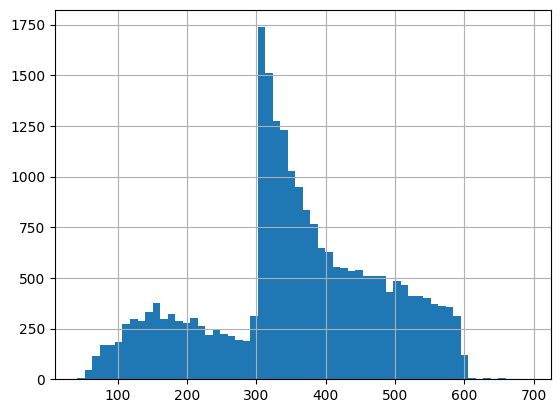

In [26]:
df['source_words'].hist(bins=60)

<Axes: >

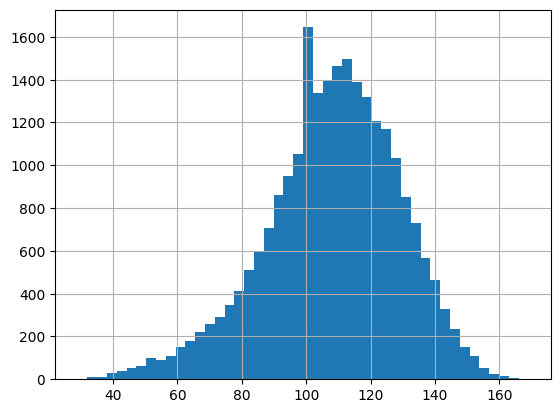

In [27]:
df['target_words'].hist(bins=46)

<Axes: >

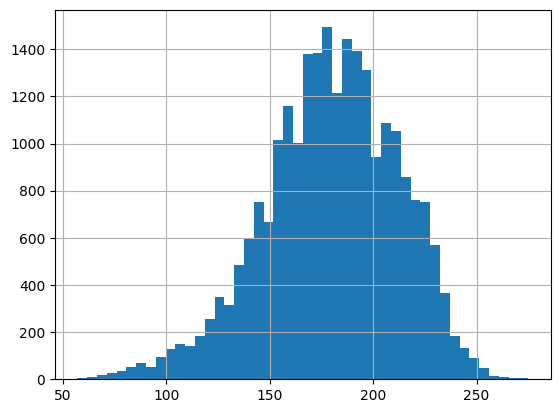

In [28]:
df['target_tokens'].hist(bins=46)

<Axes: >

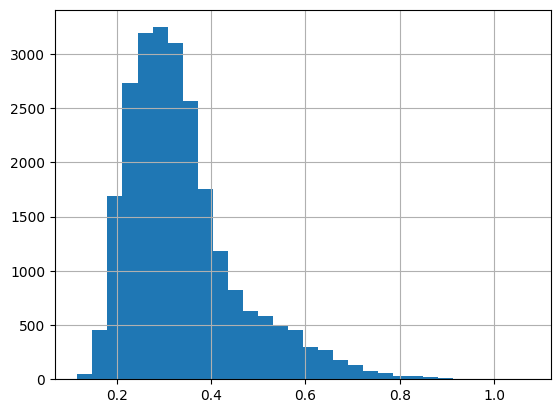

In [29]:
df['compression_ratio_words'].hist(bins=30)

In [30]:
df1 = df[df['compression_ratio_words']<=0.4]
df1.shape

(18633, 8)

# SEAHORSE

In [ ]:
from datasets import load_dataset, concatenate_datasets
seahorse = load_dataset("hgissbkh/seahorse")

In [ ]:
seahorse

In [ ]:
QUESTION = "conciseness"
LANGUAGES = ["ru", "en"]


def filter_data(example):
    if(example[QUESTION] == 0.5):
        return False

    example[QUESTION] = int(example[QUESTION])
    return example['lang'] in LANGUAGES #and len(example['summary']) > 15

seahorse_f = seahorse.filter(filter_data)

In [ ]:
full = concatenate_datasets([seahorse_f["train"], seahorse_f["validation"], seahorse_f["test"]])

In [ ]:
# full = full.map(lambda x: {"len": len(tokenizer(x["summary"])["input_ids"])})

# import pandas as pd 

# df = pd.DataFrame(full)

# print(df["len"].describe())

# df["len"].hist(bins=20)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruT5-base")
FORMAT = "тест:\n {} саммари:\n {}"

def preprocess(examples):
    inputs = [FORMAT.format(article, summary)
              for article, summary in zip(examples['text'], examples['summary'])]
    tokenized = tokenizer(inputs, truncation=False)["input_ids"]
    return {"input_ids": tokenized}


seahorse_f = seahorse_f.map(preprocess, batched=True, num_proc=16)

In [ ]:
full = concatenate_datasets([seahorse_f["train"], seahorse_f["validation"], seahorse_f["test"]])

In [ ]:
import pandas as pd

df = pd.DataFrame(full)

In [ ]:
df['sum_len'] = df['summary'].apply(len)

In [ ]:
df['sum_len'].describe()

In [ ]:
from nltk.tokenize import word_tokenize
df['sum_words'] = df['summary'].apply(lambda x: len([token for token in word_tokenize(x) if token.isalpha()]))

In [ ]:
df['sum_words'].describe()

In [ ]:
df[df.duplicated(["text", "summary"], keep=False)].sort_values("summary")

In [ ]:
print(df[QUESTION].value_counts())
df[QUESTION].value_counts().plot(kind='bar')